## Import libraries

In [34]:
# basic libraries
import json
import nltk
import string
import os

# nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# collections
from collections import defaultdict
from collections import Counter

# elasticsearch
from elasticsearch import Elasticsearch

# alchemy for language analysis
from alchemyapi import AlchemyAPI

# import life savers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# initialization
DATA_DIR = '/home/rt/wrk/w209/yelp/data'

%matplotlib inline

## Exploration

In [13]:
# creating busineses file with id, name, city, state and review count
!cat ~/wrk/w209/yelp/data/yelp_academic_dataset_business.json | jq '.business_id + "~" + .name + "~" + .city + "~" + .state + "~" + (.review_count|tostring)' | sed -e 's/"//g' > ~/wrk/w209/yelp/data/businesses.txt

In [14]:
!head ~/wrk/w209/yelp/data/businesses.txt

vcNAWiLM4dR7D2nwwJ7nCA~Eric Goldberg, MD~Phoenix~AZ~9
UsFtqoBl7naz8AVUBZMjQQ~Clancy's Pub~Dravosburg~PA~4
cE27W9VPgO88Qxe4ol6y_g~Cool Springs Golf Center~Bethel Park~PA~5
HZdLhv6COCleJMo7nPl-RA~Verizon Wireless~Pittsburgh~PA~3
mVHrayjG3uZ_RLHkLj-AMg~Emil's Lounge~Braddock~PA~11
KayYbHCt-RkbGcPdGOThNg~Alexion's Bar & Grill~Carnegie~PA~15
b12U9TFESStdy7CsTtcOeg~Flynn's E W Tire Service Center~Carnegie~PA~5
Sktj1eHQFuVa-M4bgnEh8g~Forsythe Miniature Golf & Snacks~Carnegie~PA~4
3ZVKmuK2l7uXPE6lXY4Dbg~Quaker State Construction~Carnegie~PA~3
wJr6kSA5dchdgOdwH6dZ2w~Kings Family Restaurant~Carnegie~PA~8


In [15]:
# get all business ids from reviews with line number to join with businesses.txt
!cat ~/wrk/w209/yelp/data/yelp_academic_dataset_review.json | jq '.business_id' | sed -e 's/\"//g' | awk '{print $0 "|" NR}' > ~/wrk/w209/yelp/data/all_reviews_biz_ids.txt

In [16]:
!head ~/wrk/w209/yelp/data/all_reviews_biz_ids.txt

vcNAWiLM4dR7D2nwwJ7nCA|1
vcNAWiLM4dR7D2nwwJ7nCA|2
vcNAWiLM4dR7D2nwwJ7nCA|3
vcNAWiLM4dR7D2nwwJ7nCA|4
vcNAWiLM4dR7D2nwwJ7nCA|5
vcNAWiLM4dR7D2nwwJ7nCA|6
vcNAWiLM4dR7D2nwwJ7nCA|7
vcNAWiLM4dR7D2nwwJ7nCA|8
vcNAWiLM4dR7D2nwwJ7nCA|9
vcNAWiLM4dR7D2nwwJ7nCA|10


In [19]:
# get reviews only for AZ (Arizona) state
!grep '\~AZ' ~/wrk/w209/yelp/data/businesses.txt | sort -t'~' -k5nr | awk -F'~' '{if ($5 > 50) {print $1}}' > ~/wrk/w209/yelp/data/biz_ids_50plus_rvws.txt 
!awk -F'|' 'NR==FNR{c[$1]++;next};c[$1] > 0' ~/wrk/w209/yelp/data/biz_ids_50plus_rvws.txt ~/wrk/w209/yelp/data/all_reviews_biz_ids.txt | cut -f2 -d"|" > ~/wrk/w209/yelp/data/matched_biz_rownum.txt
!awk -F'|' 'NR==FNR{c[$1]++;next};c[FNR] > 0' ~/wrk/w209/yelp/data/matched_biz_rownum.txt ~/wrk/w209/yelp/data/yelp_academic_dataset_review.json > ~/wrk/w209/yelp/data/AZ_reviews.json

In [20]:
!wc -l ~/wrk/w209/yelp/data/AZ_reviews.json

359138 /home/rt/wrk/w209/yelp/data/AZ_reviews.json


In [23]:
!awk -F'~' '{if ($5 > 50 && $4 == "AZ") {sum+=$5}} END{print sum}' businesses.txt 

386012


In [24]:
# get reviews only for NV (Nevada) state
!grep '\~NV' ~/wrk/w209/yelp/data/businesses.txt | sort -t'~' -k5nr | awk -F'~' '{if ($5 > 50) {print $1}}' > ~/wrk/w209/yelp/data/biz_ids_50plus_rvws.txt 
!awk -F'|' 'NR==FNR{c[$1]++;next};c[$1] > 0' ~/wrk/w209/yelp/data/biz_ids_50plus_rvws.txt ~/wrk/w209/yelp/data/all_reviews_biz_ids.txt | cut -f2 -d"|" > ~/wrk/w209/yelp/data/matched_biz_rownum.txt
!awk -F'|' 'NR==FNR{c[$1]++;next};c[FNR] > 0' ~/wrk/w209/yelp/data/matched_biz_rownum.txt ~/wrk/w209/yelp/data/yelp_academic_dataset_review.json > ~/wrk/w209/yelp/data/NV_reviews.json

In [25]:
!wc -l ~/wrk/w209/yelp/data/NV_reviews.json

525803 /home/rt/wrk/w209/yelp/data/NV_reviews.json


In [26]:
!awk -F'~' '{if ($5 > 50 && $4 == "NV") {sum+=$5}} END{print sum}' businesses.txt 

582970


In [29]:
# number of Alchemy API transactions required for NV
!cat ~/wrk/w209/yelp/data/NV_reviews.json | jq '.business_id + " " + (.stars | tostring)' | sort | uniq -c | wc -l

13324


In [30]:
# number of Alchemy API transactions required for AZ
!cat ~/wrk/w209/yelp/data/AZ_reviews.json | jq '.business_id + " " + (.stars | tostring)' | sort | uniq -c | wc -l

14787


#### How users are rating other businesses who have rated "Mon Ami Gabi"?

In [ ]:
!grep 4bEjOyTaDG24SY5TxsaUNQ NV_reviews.json | grep '"stars": 1' | jq '.user_id' | sort | uniq | grep -f - NV_reviews.json | grep -v 4bEjOyTaDG24SY5TxsaUNQ | jq '.stars' | sort | uniq -c

In [ ]:
!grep 4bEjOyTaDG24SY5TxsaUNQ NV_reviews.json | grep '"stars": 2' | jq '.user_id' | sort | uniq | grep -f - NV_reviews.json | grep -v 4bEjOyTaDG24SY5TxsaUNQ | jq '.stars' | sort | uniq -c

In [ ]:
!grep 4bEjOyTaDG24SY5TxsaUNQ NV_reviews.json | grep '"stars": 3' | jq '.user_id' | sort | uniq | grep -f - NV_reviews.json | grep -v 4bEjOyTaDG24SY5TxsaUNQ | jq '.stars' | sort | uniq -c

In [ ]:
!grep 4bEjOyTaDG24SY5TxsaUNQ NV_reviews.json | grep '"stars": 4' | jq '.user_id' | sort | uniq | grep -f - NV_reviews.json | grep -v 4bEjOyTaDG24SY5TxsaUNQ | jq '.stars' | sort | uniq -c

In [ ]:
!grep 4bEjOyTaDG24SY5TxsaUNQ NV_reviews.json | grep '"stars": 5' | jq '.user_id' | sort | uniq | grep -f - NV_reviews.json | grep -v 4bEjOyTaDG24SY5TxsaUNQ | jq '.stars' | sort | uniq -c

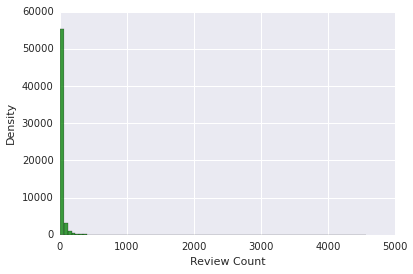

In [9]:
df = pd.read_table('./businesses.txt', sep ='~', names=['business_id', 'name', 'city', 'state', 'review_count'])
#df.hist(column = 'review_count', bins = 50, )
plt.hist(df.review_count, bins = 80, facecolor='green', alpha=0.75)

plt.xlabel('Review Count')
plt.ylabel('Density')
plt.grid(True)

plt.show()

In [ ]:
grep '\~NV' businesses.txt | sort -t$'~' -k5nr | awk -F'~' '{if ($5 > 50) {print $0}}' > businesses_w_50plus_reviews.txt
cut -d"~" -f1 businesses_w_50plus_reviews.txt > businesses_w_50plus_reviews_ids.txt
cat yelp_academic_dataset_review.json | jq '.business_id' | sed -e 's/\"//g' | awk '{print $0 "|" NR}' > all_reviews_biz_ids.txt
awk -F'|' 'NR==FNR{c[$1]++;next};c[$1] > 0' businesses_w_50plus_reviews_ids.txt all_reviews_biz_ids.txt > matched_biz.txt
cut -f2 -d"|" matched_biz.txt > matched_biz_rownum.txt
awk -F'|' 'NR==FNR{c[$1]++;next};c[FNR] > 0' matched_biz_rownum.txt yelp_academic_dataset_review.json > NV_reviews.json

## Data Cleansing - Tokenize and Stemming using NLTK

In [2]:
# utility function to parse and return json
def process_json(filename):
    result = []

    infile = open(filename,"r")

    for line in infile:
        temp = json.loads( line.strip() )
        if 'create' in temp:
            continue
        result.append(temp)

    return result

In [53]:
def process_review(src_file_name, tgt_file_name):
    print "processing file name {}".format(src_file_name)

    reviews = process_json(src_file_name)
    print "# of reviews: {}".format(len(reviews))

    ids_hash = defaultdict(list)
    ids = {v['business_id']:v for v in reviews}.keys()
    #ids = ['6imLt53br7SJ3av07jjH7w', '41j3GB7M-Lwq284Pfb9zgw']

    reviews_text = ""

    # initialize tokenizer and stemmer
    tokenization_pattern = r'''(?x)    # set flag to allow verbose regexps
    ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
    | \w+(-\w+)*        # words with optional internal hyphens
    | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
    | \w+[\x90-\xff]  # these are escaped emojis
    | [][.,;"'?():-_`]  # these are separate tokens
    '''
    word_tokenizer = nltk.tokenize.regexp.RegexpTokenizer(tokenization_pattern)
    porter_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()

    for item in reviews:
        tokens = word_tokenizer.tokenize(item['text'].lower())
        normalized = [w for w in tokens if w.lower() not in stopwords.words('english')]
        #stemmed_reviews.append(' '.join(map(porter_stemmer.stem, normalized)))
        treated_review = ' '.join(map(wordnet_lemmatizer.lemmatize, normalized))
        ids_hash[(item['business_id'], item['stars'])].append(treated_review)
        
    print "Length of treated reviews = {}".format(len(ids_hash))
    #print ids_hash
    
    nlp_process(ids, ids_hash, tgt_file_name)
    #print stemmed_review_blob

In [55]:
#src_file_name = os.path.join(DATA_DIR, 'mon.ami.gabi.reviews.json')
#tgt_file_name = os.path.join(DATA_DIR, 'analysis.mon.ami.gabi.out')
src_file_name = os.path.join(DATA_DIR, 'phoenix_bars.json')
tgt_file_name = os.path.join(DATA_DIR, 'analysis.phoenix_bars.out')
process_review(src_file_name, tgt_file_name)

processing file name /home/rt/wrk/w209/yelp/data/phoenix_bars.json
# of reviews: 864
Length of treated reviews = 10
processing business 41j3GB7M-Lwq284Pfb9zgw for review with 1 star(s)
#Success#
100 7
processing business 41j3GB7M-Lwq284Pfb9zgw for review with 2 star(s)
#Success#
99 7
processing business 41j3GB7M-Lwq284Pfb9zgw for review with 3 star(s)
#Success#
100 5
processing business 41j3GB7M-Lwq284Pfb9zgw for review with 4 star(s)
#Success#
100 8
processing business 41j3GB7M-Lwq284Pfb9zgw for review with 5 star(s)
#Success#
100 8
processing business 6imLt53br7SJ3av07jjH7w for review with 1 star(s)
#Success#
99 2
processing business 6imLt53br7SJ3av07jjH7w for review with 2 star(s)
#Success#
100 5
processing business 6imLt53br7SJ3av07jjH7w for review with 3 star(s)
#Success#
99 8
processing business 6imLt53br7SJ3av07jjH7w for review with 4 star(s)
#Success#
100 8
processing business 6imLt53br7SJ3av07jjH7w for review with 5 star(s)
#Success#
99 8


## Sentiment Analysis and Topic Modeling using Alchemy API

In [57]:
def nlp_process(ids,ids_hash, tgt_file_name):
    #instantiate an elasticsearch client
    #es = Elasticsearch()
    outfile = open(tgt_file_name, 'w')

    #instantiate an alchemy client
    alchemyapi = AlchemyAPI()

    for business_id in ids:
        for star in range(1,6):
            print "processing business {} for review with {} star(s)".format(business_id, star)
            data = '.'.join(ids_hash[(business_id, star)])
            alchem_keywords = []
            alchem_concepts = []

            if len(data) >= 100:
                response = alchemyapi.combined('text', data, {'sentiment': 1, 'maxRetrieve': 100})

                if response['status'] == 'OK':
                    print('#Success#')
                    for keyword in response['keywords']:
                        al_temp = defaultdict()

                        al_temp['text'] = keyword['text'].encode('utf-8')
                        al_temp['relevance'] = keyword['relevance']
                        al_temp['sentiment'] = keyword['sentiment']['type']

                        if 'score' in keyword['sentiment']:
                            al_temp['score'] = keyword['sentiment']['score']

                        alchem_keywords.append(al_temp)

                    for keyword in response['concepts']:
                        al_temp = defaultdict()

                        al_temp['text'] = keyword['text'].encode('utf-8')
                        al_temp['relevance'] = keyword['relevance']

                        alchem_concepts.append(al_temp)

                else:
                    print('Error in keyword extaction call: ', response['statusInfo'])
                print len(alchem_keywords), len(alchem_concepts)

                # prepare body for insertion
                doc = {
                    "business_id" : business_id,
                    "stars": star,
                    "word_freq": alchem_keywords,
                    "topics": alchem_concepts
                }

                json.dump(doc, outfile)
                outfile.write('\n')

In [33]:
nlp_process(ids, ids_hash)

#Success#
99 8
#Success#
100 8


In [10]:
ids_hash

NameError: name 'ids_hash' is not defined

## Results

In [51]:
def nlp_results(file_name):
    infile = open(file_name, "r")

    business_names = { k:v for k, v in (line.split("~")[0:2] for line in open(os.path.join(DATA_DIR, 'businesses.txt')).read().strip().split('\n')) }
    
    for line in infile.readlines():
        line = json.loads( line.strip() )
        
        print "="*80
        print "business_id : {} | stars: {}".format(business_names.get(line['business_id'], line['business_id']), line['stars'])
        print "="*80

        print "concepts"
        print "-"*80
        print "{0: <50} | {1}".format('text', 'relevance')
        print "-"*80
        for items in line['topics']:
            #print items
            print "{0: <50} | {1}".format(items['text'].encode('utf-8'), items['relevance'])
        print "-"*80

        print "keywords"    
        print "-"*80
        print "{0: <50} | {1: <10} | {2: <10} | {3}".format('text', 'sentiment', 'score', 'relevance')
        print "-"*80
        positive = []
        negative = []
        for items in line['word_freq']:
            if items['sentiment'] == 'positive':
                positive.append( (items['score'], items['text']))
            if items['sentiment'] == 'negative':
                negative.append( (items['score'], items['text']))
        
        top_positive = sorted(positive, key=lambda x: x[0], reverse=True)[:10]
        top_negative = sorted(negative, key=lambda x: x[0], reverse=True)[:10]
        
        for (score, text) in top_positive:
            print "{0: <50} | {1: <10} | {2}".format(text, 'positive', score)
        for (score, text) in top_negative:
            print "{0: <50} | {1: <10} | {2}".format(text, 'negative', score)

        print "-"*80

In [54]:
tgt_file_name = os.path.join(DATA_DIR, 'analysis.NV_reviews.out')
nlp_results(tgt_file_name)

business_id : Mixers Ice Cream & Boba | stars: 1
concepts
--------------------------------------------------------------------------------
text                                               | relevance
--------------------------------------------------------------------------------
Ice cream                                          | 0.986396
Baskin-Robbins                                     | 0.869123
Glendale, California                               | 0.672618
Burt Baskin                                        | 0.650301
--------------------------------------------------------------------------------
keywords
--------------------------------------------------------------------------------
text                                               | sentiment  | score      | relevance
--------------------------------------------------------------------------------
stomach ache                                       | negative   | -0.571617
baskin robbins                                     |

UnicodeEncodeError: 'ascii' codec can't encode character u'\xfb' in position 2: ordinal not in range(128)

In [50]:
business_names = { k:v for k, v in (line.split("~")[0:2] for line in open(os.path.join(DATA_DIR, 'businesses.txt')).read().strip().split('\n')) }

In [48]:
a = [ line.split("~")[0:2] for line in open(os.path.join(DATA_DIR, 'businesses.txt')).read().strip().split('\n') ]

In [49]:
a[0:1]

[['vcNAWiLM4dR7D2nwwJ7nCA', 'Eric Goldberg, MD']]